# Training a Quantized NN for Modulation Classification


In [1]:
# Import some general modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from datetime import datetime
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pathlib import Path
import h5py as h5
#from torchsummary import summary
from sklearn.metrics import classification_report
import brevitas 
import brevitas.quant as quant
import os
import sys

import subprocess

docker_uname = subprocess.check_output(['id', '-un']).decode('utf-8').strip().lower()


path_to_vitis_hls = "/home/phu/Vivado/Vitis_HLS/2024.1/bin"

# Split the current PATH into a list, while removing duplicates
current_path_list = list(dict.fromkeys(os.environ["PATH"].split(os.pathsep)))

# Check if the path is already in the PATH variable
if path_to_vitis_hls not in current_path_list:
    current_path_list.insert(0, path_to_vitis_hls)  # Add to the front
    print('added')

# Join the list back into a single string
os.environ["PATH"] = os.pathsep.join(current_path_list)

os.environ["FINN_BUILD_DIR"]=f"/home/phu/repos/PytorchModClass/tmp/finn_dev_{docker_uname}"
os.environ["FINN_ROOT"]="/home/phu/repos/PytorchModClass/finn"
os.environ["VIVADO_PATH"]=" /home/phu/Vivado/Vivado/2024.1"
os.environ["HLS_PATH"]="/home/phu/Vivado/Vitis_HLS/2024.1"

added


In [2]:
# Import some general modules
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [3]:
# Select which GPU to use (if available)
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

Using GPU 0


# The RadioML 2021 Dataset <a id='load_dataset'></a>

The dataset comes in hdf5 format and exhibits the following structure:
- 27 modulations
- 26 SNRs per modulation (-20 dB through +30 dB in steps of 2)
- 4096 frames per modulation-SNR combination
- 1024 complex time-series samples per frame
- Samples as floating point in-phase and quadrature (I/Q) components, resulting in a (1024,2) frame shape
- 2.875.392 frames in total
- Value is in int8 [-128, 127]



In [4]:
# Check if dataset is present
import os.path
dataset_path = "datasets/RADIOML_2021_07_INT8/RADIOML_2021_07_INT8.hdf5"
os.path.isfile(dataset_path)

True

In [14]:
# Prepare data loader
from torch.utils.data import Dataset, DataLoader
import h5py

class radioml_21_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_21_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = [
                "OOK",
                "4ASK",
                "8ASK",
                "BPSK",
                "QPSK",
                "8PSK",
                "16PSK",
                "32PSK",
                "16APSK",
                "32APSK",
                "64APSK",
                "128APSK",
                "16QAM",
                "32QAM",
                "64QAM",
                "128QAM",
                "256QAM",
                "AM-SSB-WC",
                "AM-SSB-SC",
                "AM-DSB-WC",
                "AM-DSB-SC",
                "FM",
                "GMSK",
                "OQPSK",
                "BFSK",
                "4FSK",
                "8FSK",
            ]
        self.num_classes=len(self.mod_classes)
        # print(np.unique(self.snr))
        # print(self.data.shape)
        # print(np.min(self.data),'   ',np.max(self.data),'  ',self.data.dtype)
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB, with step of 2 --> 26 snrs

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2021)

        train_indices = []
        test_indices = []
        for mod in range(0, len(self.mod_classes)): # all modulations (0 to 26)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                #4096 is the number of frames per modulation-snr pair combination. 2875392 / (27*26) = 4096
                start_idx = 26*4096*mod + 4096*snr_idx 
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_21_dataset(dataset_path)

[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
(2875392, 1024, 2)
-112     127    int8


Modulation: 8FSK, SNR: 30.0 dB, Index: 2871419


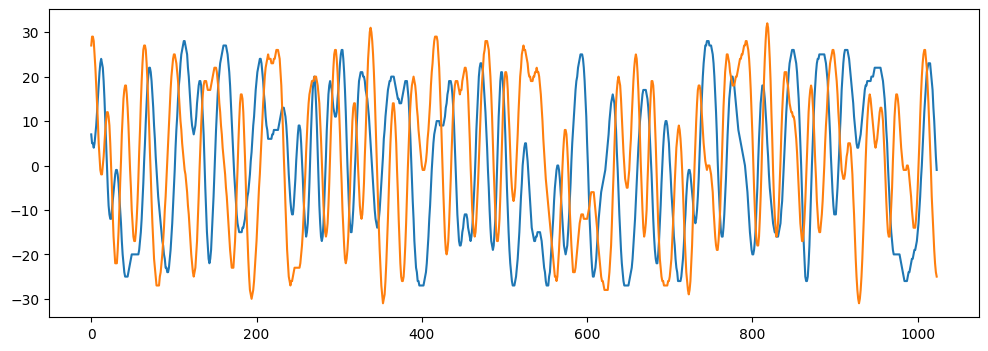

In [15]:
# Inspect a frame
mod = 26 # 0 to 26
snr_idx = 25 # 0 to 25 = -20dB to +30dB
sample = 123 # 0 to 4095
#-----------------------#
idx = 26*4096*mod + 4096*snr_idx + sample
data, mod, snr = dataset.data[idx], dataset.mod[idx], dataset.snr[idx]
plt.figure(figsize=(12,4))
plt.plot(data)
print("Modulation: %s, SNR: %.1f dB, Index: %d" % (dataset.mod_classes[mod], snr, idx))

# Define the QNN Model <a id='define_model'></a>

<div>
<img align="right" width="274" height="418" src="attachment:VGG10_small.png">
</div>

As a simple example, we will create a quantized version of the "VGG10" CNN architecture proposed by the dataset authors in [Over-the-Air Deep Learning Based Radio Signal Classification](https://arxiv.org/pdf/1712.04578.pdf).

Quantizing a sequential pytorch model is straightforward with Brevitas. Relevant `torch.nn` layers are simply replaced by their `brevitas.nn` counterparts, which add customizable input, output, or parameter quantization. Regular Torch layers, especially those that are invariant to quantization (e.g. BatchNorm or MaxPool), can be mixed and matched with Brevitas layers.

As a baseline, we apply 8-bit quantization to the activations and weights of every layer, except for the final classification output. The input data is quantized to 8 bits with a dedicated quantization layer. Instead of letting Brevitas determine the quantization scale automatically, we set a fixed quantization range (-2.0, 2.0) based on analysis of the whole dataset. Except for two outlier classes (both single-sideband (SSB) modulations), the vast majority of samples (98.3%) at +30 dB fall within this range and will thus not be clipped.

For more information on Brevitas you can turn to these resources:
- [GitHub repository](https://github.com/Xilinx/brevitas)
- [Tutorial notebooks](https://github.com/Xilinx/brevitas/tree/master/notebooks)
- [Example models](https://github.com/Xilinx/brevitas/tree/master/src/brevitas_examples)
- Public discussion in the [Brevitas Gitter channel](https://gitter.im/xilinx-brevitas/community)

In [39]:
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import Int8Bias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit

# Adjustable hyperparameters
input_bits = 8
a_bits = 4
w_bits = 4
filters_conv = 64
filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    bit_width = input_bits
    #Normalizing the input range to [0,1]
    #Because our input is int8 [-128, 127], we need to convert them to float32 [0.0, 1.0] for internal nodes to process. 
    min_val = -128.0
    max_val = 127.0
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

model_class = nn.Sequential(
    # Input quantization layer
    qnn.QuantHardTanh(act_quant=InputQuantizer),

    qnn.QuantConv1d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits,bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),
    
    nn.Flatten(),

    qnn.QuantLinear(filters_conv*8, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits),

    qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

    qnn.QuantLinear(filters_dense, 27, weight_bit_width=w_bits, bias=True, bias_quant=Int8Bias),
)
model=model_class

import torchinfo
print(torchinfo.summary(model_class,input_size=(1,2,1024)))

Layer (type:depth-idx)                                            Output Shape              Param #
Sequential                                                        [1, 27]                   --
├─QuantHardTanh: 1-1                                              [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-1                             [1, 2, 1024]              --
│    └─ActQuantProxyFromInjector: 2-2                             [1, 2, 1024]              --
│    │    └─FusedActivationQuantProxy: 3-1                        [1, 2, 1024]              --
├─QuantReLU: 1-50                                                 --                        (recursive)
│    └─ActQuantProxyFromInjector: 2-59                            --                        (recursive)
│    │    └─FusedActivationQuantProxy: 3-34                       --                        (recursive)
├─QuantHardTanh: 1-3                                              --                        --
│    └─ActQuantPro

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


# Train the QNN from Scratch <a id='train_model'></a>
<span style="color:red">Even with GPU acceleration, training will take multiple minutes per epoch!<br>You can skip this section and load a pre-trained model instead: [Load Pre-Trained Parameters](#load_trained_model)</span>

First, we define basic train and test functions, which will be called for each training epoch. Training itself follows the usual Pytorch procedures, while Brevitas handles all quantization-specifics automatically in the background.

In [40]:
from sklearn.metrics import accuracy_score

def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.train()    

    for (inputs, target, snr) in tqdm(train_loader, desc="Training Batches", leave=False):   
        if gpu is not None:
            inputs = inputs.to('cuda')
            target = target.to('cuda')
                
        # forward pass
        output = model(inputs)
        loss = criterion(output, target)
        
        # backward pass + run optimizer to update weights
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().detach().numpy())
           
    return losses

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for (inputs, target, snr) in tqdm(test_loader, desc="Testing Batches", leave=False):
            if gpu is not None:
                inputs = inputs.to('cuda')
                target = target.to('cuda')
            output = model(inputs)
            pred = output.argmax(dim=1, keepdim=True)
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
        
    return accuracy_score(y_true, y_pred)

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

Now we can start the training loop for a number of epochs.

If you run into VRAM limitations of your system, it might help to decrease the `batch_size` and initial learning rate accordingly. To keep this notebook's resource footprint small, we do not pre-load the whole dataset into DRAM. You should adjust your own training code to take advantage of multiprocessing and available memory for maximum performance.

In [41]:
batch_size = 1024
num_epochs = 20

data_loader_train = DataLoader(dataset, batch_size=batch_size, sampler=dataset.train_sampler)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

if gpu is not None:
    model = model.to('cuda')

# loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
if gpu is not None:
    criterion = criterion.to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=1)

running_loss = []
running_test_acc = []

for epoch in tqdm(range(num_epochs), desc="Epochs"):
        print('training')
        loss_epoch = train(model, data_loader_train, optimizer, criterion)
        print('testing')
        test_acc = test(model, data_loader_test)
        print("Epoch %d: Training loss = %f, test accuracy = %f" % (epoch, np.mean(loss_epoch), test_acc))
        running_loss.append(loss_epoch)
        running_test_acc.append(test_acc)
        lr_scheduler.step()

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

training


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

testing


Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 0: Training loss = 1.517371, test accuracy = 0.545212
training


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


testing


Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 1: Training loss = 1.326267, test accuracy = 0.567320
training


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


testing


Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 2: Training loss = 1.277071, test accuracy = 0.581985
training


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


testing


Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 3: Training loss = 1.244512, test accuracy = 0.590824
training


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


testing


Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 4: Training loss = 1.220908, test accuracy = 0.604631
training


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


testing


Testing Batches:   0%|          | 0/282 [00:00<?, ?it/s]

Epoch 5: Training loss = 1.265491, test accuracy = 0.585616
training


Training Batches:   0%|          | 0/2527 [00:00<?, ?it/s]

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


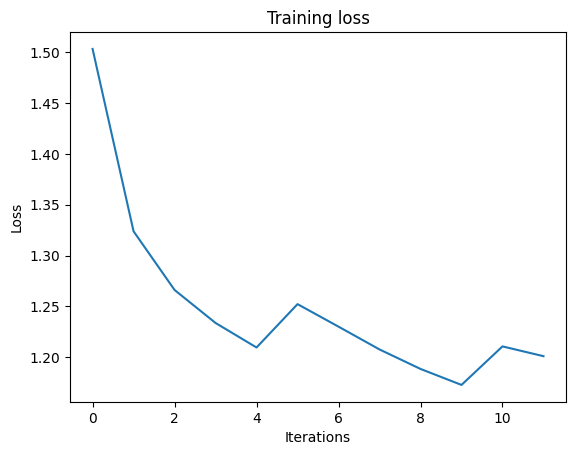

In [22]:
# Plot training loss over epochs
loss_per_epoch = [np.mean(loss_per_epoch) for loss_per_epoch in running_loss]
display_loss_plot(loss_per_epoch)

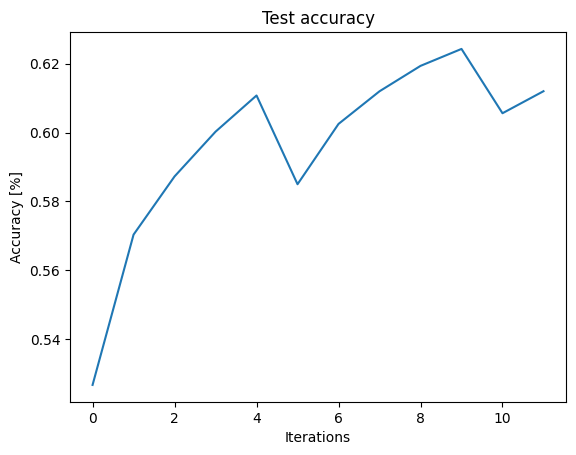

In [23]:
# Plot test accuracy over epochs
acc_per_epoch = [np.mean(acc_per_epoch) for acc_per_epoch in running_test_acc]
display_loss_plot(acc_per_epoch, title="Test accuracy", ylabel="Accuracy [%]")

In [24]:
# Save the trained parameters to disk
Path("27ml_rf").mkdir(exist_ok=True)
torch.save(model.state_dict(), "27ml_rf/model_trained.pth")

# Load a Trained Model <a id='load_trained_model'></a>
Alternatively, you can load the provided pre-trained model.
It was trained for 20 epochs and reaches an overall accuracy of 59.5%.

In [25]:
# # Load trained parameters
# savefile = "models/pretrained_VGG10_w8a8_20.pth"
# saved_state = torch.load(savefile, map_location=torch.device("cpu"))
# model.load_state_dict(saved_state)
# if gpu is not None:
#     model = model.cuda()
model=model_class
model.load_state_dict(torch.load("27ml_rf/model_trained.pth"))
model.to('cuda')

/tmp/ipykernel_3598902/2725553782.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("27ml_rf/model_trained.pth"))


Sequential(
  (0): QuantHardTanh(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
            (input_view_impl): Identity()
          )
          (scaling_impl): ConstScaling(
            (restrict_clamp_scaling): _RestrictClampValue(
              (clamp_min_ste): Identity()
              (restrict_value_impl): FloatRestrictValue()
            )
            (restrict_init_module): Identity()
            (value): StatelessBuffer()
          )
          (int_scaling_impl): IntScaling()
      

# Evaluate the Accuracy <a id='evaluate_accuracy'></a>
The following cells visualize the test accuracy across different modulations and signal-to-noise ratios. Submissions for this problem statement must reach an overall accuracy of at least **56.0%**, so this should give you an idea what makes up this figure.

In [26]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_21_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

[-20 -18 -16 -14 -12 -10  -8  -6  -4  -2   0   2   4   6   8  10  12  14
  16  18  20  22  24  26  28  30]
(2875392, 1024, 2)
-112     127    int8


In [27]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
y_pred = np.empty((0,len(dataset.mod_classes)))
model.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output = model(inputs)
        y_pred = np.concatenate((y_pred,output.cpu()))
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/282 [00:00<?, ?it/s]

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/torch/nn/modules/conv.py:304: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  return F.conv1d(input, weight, bias, self.stride,
/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/brevitas/nn/quant_linear.py:69: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:294.)
  output_tensor = linear(x, quant_weight, quant_bias)


Overall Accuracy across all SNRs: 0.615746


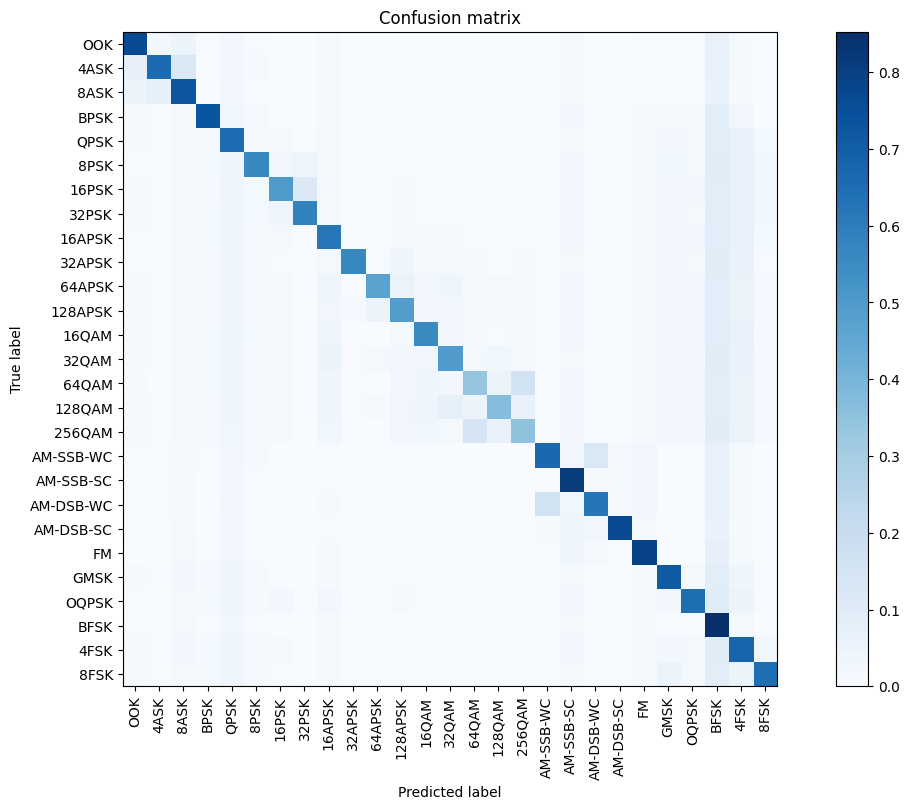

In [28]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
for i in range(len(y_exp)):
    j = int(y_exp[i])
    k = int(np.argmax(y_pred[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(dataset.mod_classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm, labels=dataset.mod_classes)

cor = np.sum(np.diag(conf))
ncor = np.sum(conf) - cor
print("Overall Accuracy across all SNRs: %f"%(cor / (cor+ncor)))

/tmp/ipykernel_3598902/3267716818.py:22: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221+plot)


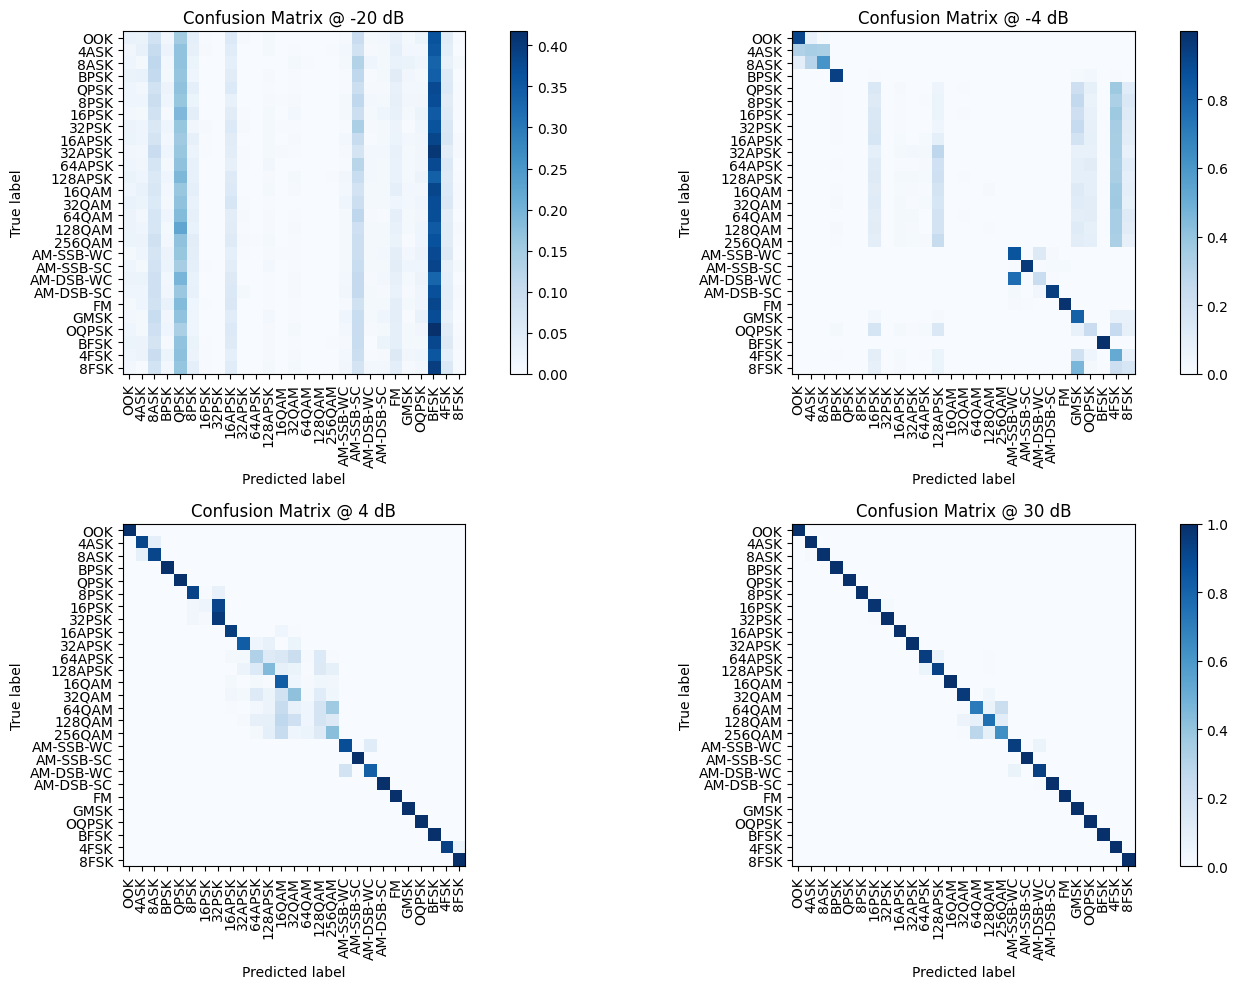

In [29]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred[indices_snr]
 
    conf = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    acc.append(cor/(cor+ncor))

Accuracy @ highest SNR (+30 dB): 0.954291
Accuracy overall: 0.615746


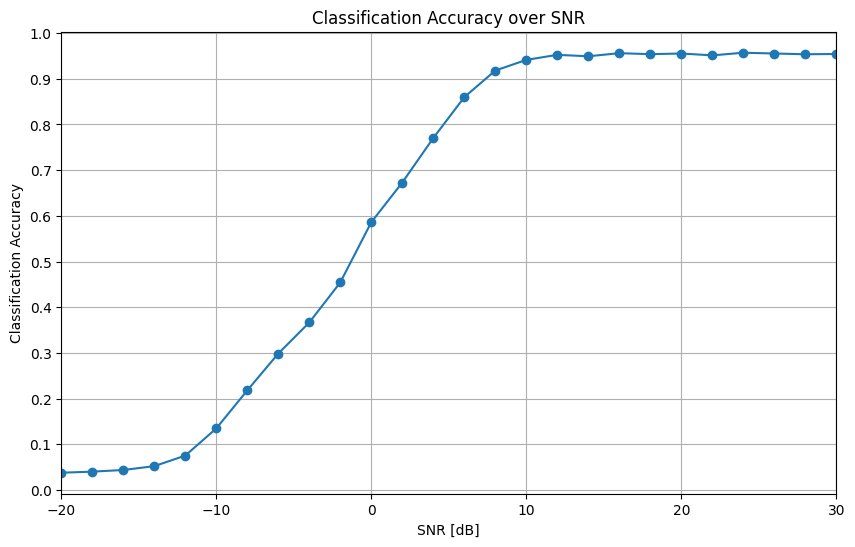

In [30]:
# Plot accuracy over SNR
plt.figure(figsize=(10,6))
plt.plot(dataset.snr_classes, acc, marker='o')
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR");

print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))

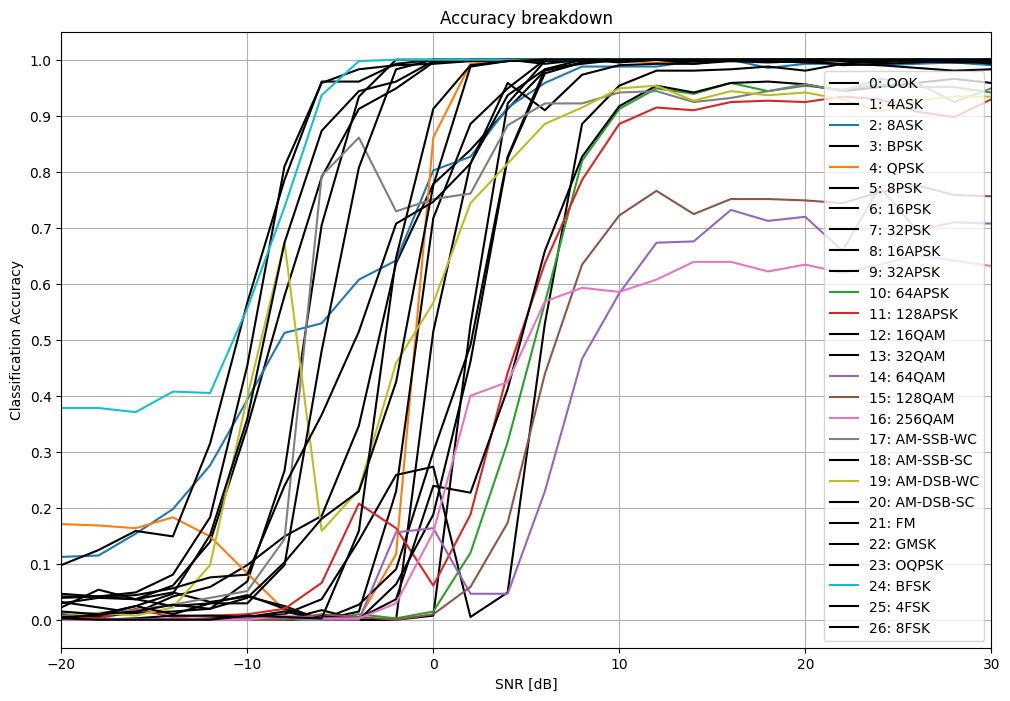

In [31]:
# Plot accuracy per modulation
accs = []
for mod in range((dataset.num_classes)):
    accs.append([])
    for snr in dataset.snr_classes:
        indices = ((y_exp == mod) & (y_snr == snr)).nonzero()
        y_exp_i = y_exp[indices]
        y_pred_i = y_pred[indices]
        cor = np.count_nonzero(y_exp_i == np.argmax(y_pred_i, axis=1))
        accs[mod].append(cor/len(y_exp_i))
        
# Plot accuracy-over-SNR curve
plt.figure(figsize=(12,8))
for mod in range(dataset.num_classes):
    if accs[mod][-1] < 0.95 or accs[mod][0] > 0.1:
        color = None
    else:
        color = "black"
    plt.plot(dataset.snr_classes, accs[mod], label=str(mod) + ": " + dataset.mod_classes[mod], color=color)
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Accuracy breakdown")
plt.grid()
plt.legend();

In [34]:
import torch
import onnx
from finn.util.test import get_test_model_trained
from brevitas.export import export_qonnx,export_brevitas_onnx
from qonnx.util.cleanup import cleanup as qonnx_cleanup
from qonnx.core.modelwrapper import ModelWrapper
from finn.transformation.qonnx.convert_qonnx_to_finn import ConvertQONNXtoFINN
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.fold_constants import FoldConstants
from qonnx.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from qonnx.util.cleanup import cleanup_model
import os 
import onnx

Path("27ml_rf/models").mkdir(exist_ok=True)
model=model_class
model.load_state_dict(torch.load("27ml_rf/model_trained.pth"))
model.to('cuda')

model.eval()
build_dir="27ml_rf/models"
export_path=f"{build_dir}/radio_27ml_export.onnx"
export_qonnx(model.to('cuda'), torch.randn(1, 2, 1024).to('cuda'), export_path=export_path);
#export_brevitas_onnx(model.cpu(),torch.randn(1, 2, 1024),export_path=export_path)

/tmp/ipykernel_3598902/389701898.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("27ml_rf/model_trained.pth"))


In [38]:
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.infer_data_layouts import InferDataLayouts
from qonnx.transformation.insert_topk import InsertTopK
from qonnx.transformation.general import (
    ConvertSubToAdd,
    ConvertDivToMul,
    GiveReadableTensorNames,
    GiveUniqueNodeNames,
    SortGraph,
    RemoveUnusedTensors,
    GiveUniqueParameterTensors,
    RemoveStaticGraphInputs,
    ApplyConfig,
)
import onnx
from onnx import TensorProto, helper
from qonnx.core.datatype import DataType


#Main goal is to skip the first multithreshold node.
#The first multithreshold node is the quantizing data node.
#Because on FPGA we will preprocess the data before forwarding through model, 
#we will remove the first multithreshold node.
model = ModelWrapper(export_path)
model = model.transform(ConvertQONNXtoFINN())
model.save(f"{build_dir}/radio_27ml_finn.onnx")
# tidy up
finn_model = ModelWrapper(f"{build_dir}/radio_27ml_finn.onnx")

finn_model = finn_model.transform(InferShapes())
finn_model = finn_model.transform(InferDataTypes())
finn_model = finn_model.transform(GiveUniqueNodeNames())
finn_model = finn_model.transform(GiveReadableTensorNames())
finn_model.cleanup()

# extract input quantization thresholds for sw-based quantization
# (in case they were not fixed before training)
input_mt_node = finn_model.get_nodes_by_op_type("MultiThreshold")[0]
input_mt_thresholds = finn_model.get_initializer(input_mt_node.input[1])
print("input quant thresholds")
print(input_mt_thresholds)

# preprocessing: remove input reshape/quantization from graph
new_input_node = finn_model.get_nodes_by_op_type("Conv")[0]   # <---- Change this to the name of the node that has its input node the new desired input graph node.
new_input_tensor = finn_model.get_tensor_valueinfo(new_input_node.input[0]) #<--- Get the input node that lead to Conv node or whatever node you just changed above
old_input_tensor = finn_model.graph.input[0]  # <--- Get the current starting node 
finn_model.graph.input.remove(old_input_tensor) #<--- Remove the current starting node
finn_model.graph.input.append(new_input_tensor) #<--- Make the [Node before the Conv node] the starting node
new_input_index = finn_model.get_node_index(new_input_node)
del finn_model.graph.node[0:new_input_index] #<--- Delete every node before the new starting node

#We dont have softmax node but still run it anyway
# postprocessing: remove final softmax node from training
softmax_node = finn_model.graph.node[-1]
softmax_in_tensor = finn_model.get_tensor_valueinfo(softmax_node.input[0])
softmax_out_tensor = finn_model.get_tensor_valueinfo(softmax_node.output[0])
finn_model.graph.output.remove(softmax_out_tensor)
finn_model.graph.output.append(softmax_in_tensor)
finn_model.graph.node.remove(softmax_node)

# remove redundant value_info for primary input/output
# othwerwise, newer FINN versions will not accept the model
if finn_model.graph.input[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.input[0])
if finn_model.graph.output[0] in finn_model.graph.value_info:
    finn_model.graph.value_info.remove(finn_model.graph.output[0])

# insert topK node in place of the final softmax node
# topK plays similar role to softmax
# k=1 means it pick only 1 class with highest predictions value
finn_model = finn_model.transform(InsertTopK(k=1))

# manually set input datatype (not done by brevitas yet)
finnonnx_in_tensor_name = finn_model.graph.input[0].name
finnonnx_model_in_shape = finn_model.get_tensor_shape(finnonnx_in_tensor_name)
finn_model.set_tensor_datatype(finnonnx_in_tensor_name, DataType["INT8"])
print("Input tensor name: %s" % finnonnx_in_tensor_name)
print("Input tensor shape: %s" % str(finnonnx_model_in_shape))
print("Input tensor datatype: %s" % str(finn_model.get_tensor_datatype(finnonnx_in_tensor_name)))

# save modified model that is now ready for the FINN compiler
finn_model.save(f"{build_dir}/radio_27ml_tidy.onnx")
print("Modified FINN-ready model saved to %s" % f"{build_dir}/radio_27ml_tidy.onnx")

/home/phu/anaconda3/envs/torch_resnet/lib/python3.8/site-packages/qonnx/transformation/gemm_to_matmul.py:57: UserWarning: The GemmToMatMul transformation only offers explicit support for version 9 of the Gemm node, but the ONNX version of the supplied model is 17. Thus the transformation may fail or return incomplete results.
  warnings.warn(


input quant thresholds
[[-127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5 -119.5 -118.5
  -117.5 -116.5 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5 -109.5 -108.5
  -107.5 -106.5 -105.5 -104.5 -103.5 -102.5 -101.5 -100.5  -99.5  -98.5
   -97.5  -96.5  -95.5  -94.5  -93.5  -92.5  -91.5  -90.5  -89.5  -88.5
   -87.5  -86.5  -85.5  -84.5  -83.5  -82.5  -81.5  -80.5  -79.5  -78.5
   -77.5  -76.5  -75.5  -74.5  -73.5  -72.5  -71.5  -70.5  -69.5  -68.5
   -67.5  -66.5  -65.5  -64.5  -63.5  -62.5  -61.5  -60.5  -59.5  -58.5
   -57.5  -56.5  -55.5  -54.5  -53.5  -52.5  -51.5  -50.5  -49.5  -48.5
   -47.5  -46.5  -45.5  -44.5  -43.5  -42.5  -41.5  -40.5  -39.5  -38.5
   -37.5  -36.5  -35.5  -34.5  -33.5  -32.5  -31.5  -30.5  -29.5  -28.5
   -27.5  -26.5  -25.5  -24.5  -23.5  -22.5  -21.5  -20.5  -19.5  -18.5
   -17.5  -16.5  -15.5  -14.5  -13.5  -12.5  -11.5  -10.5   -9.5   -8.5
    -7.5   -6.5   -5.5   -4.5   -3.5   -2.5   -1.5   -0.5    0.5    1.5
     2.5    3.5    4.5    5.5    6.5    7